
# Creation of a quantization, use and evaluation pipeline, featuring LLaMA2 7B model and HQQ

In this project, we evaluate the impact quantization has in a common use LLM model, in our case LLaMA 2 7B, evaluating it in a sentiment analysis task. Our pipeline is defined as follows:
- Add a classification layer at the end of the not-quantized model and train this new model with our dataset.
- Quantize the model using **HQQ** in three variants, 8bit, 4 bit and 3bit quantization.
- Compare the performance of our models (not quantized, 4bits 8bits and 3 bits) in terms of precission, memory use, inference speed and emissions.

![Pipeline Diagram](./HQQ_Pipeline.png)

We follow this approach because it is the easiest approach to follow. Another option would be to firstly quantize the base model and then add the classification layer and train it. In fact, one could think this approach is better than the previously exposed. However, lots of problems are encountered doing this because fine tuning an already quantized model is not a good practice. 

### Goals
1. Analize the impact quantization has on performance.
2. Compare the efficiency and precision of the quantized models with the not-quantized model.


## HQQ

HQQ (Half-Quadratic Quantization) is an advanced post-training quantization (PTQ) method designed to optimize large language models quickly and efficiently. It focuses on minimizing weight quantization error through a semi-quadratic optimization approach. Unlike gradient-based methods, HQQ does not require calibration data, making it significantly faster—up to 100 times quicker than traditional techniques like GPTQ. This allows models such as LLaMA-2-70B to be quantized in under five minutes, making it ideal for deployment in environments with limited computational resources.

The core principle of HQQ is its optimization-based approach, which minimizes the error between original and quantized weights. Instead of relying on calibration data or gradients, HQQ formulates quantization as an optimization problem using a sparse-aware loss function. This helps mitigate the impact of outliers and ensures that critical weight structures are preserved.

The HQQ process follows these steps:

- Problem Formulation: Quantization is modeled as an optimization problem focused on weight errors rather than activations.
- Semi-Quadratic Solution: A mathematical approach provides a closed-form solution, eliminating the need for expensive iterative computations.
- Fast Execution: Due to its efficient formulation, HQQ performs quantization in minutes, even for models with billions of parameters.
- Inference with HQQ-quantized models benefits from significant memory reduction while maintaining model accuracy. By preserving critical weight structures and leveraging a highly efficient optimization strategy, HQQ achieves an optimal balance between computational efficiency and predictive performance.

In summary, HQQ represents a major advancement in large-scale model quantization, combining speed, accuracy, and efficiency without requiring calibration data. This makes it a crucial tool for deploying modern language models in resource-constrained settings.

## Hardware and software

### Hardware
- CPU: Intel(R) Xeon(R) Silver 4316 CPU @ 2.30GHz
- RAM: 985 GB
- GPU: NVIDIA A100-PCIE-40GB
### Software
For this project, we used the following python libraries: torch, transformers, time and datasets, among others. Of course, all the libraries that these libraries have dependencies with are needed too.
We also used some other libraries or tools that help to evaluate the results. For example, the library CodeCarbon was used to collect emissions data, and the Weights and Biases (Wandb) platform was used to collect and visualize metrics. 


## Project pipeline

### 1. Base model preparation
The base model used is **LLaMA 2 (7B)**. We added a classifier layer to it by loading it with the LlamaForSequenceClassification function from the Transformers library. Then, fine tuning was performed using the **TweetEval** dataset, focusing on the sentiment classification task on its training subset. To make the fine-tuning more efficient and lightweight, Low-Rank Adaptation (LoRA) was applied to the attention layers using the PEFT library, reducing the number of trainable parameters. Training was carried out on a single  NVIDIA A100 40GB GPU using the Hugging Face ***Trainer*** API with a learning rate of $2 \times 10^{-5}$, a batch size of 8, and a total of 3 epochs.


### 2. Quantization 
Quantization was performed using **GPTQ**. With this quantization method we took 3 quantization options: **8 bits**, **4 bits** and **3 bits**.
This leads us to have 4 different models: **quantized to 8 bits**, **quantized to 4 bits**, **quantized to 3 bits** and **not quantized**.

### 3. Evaluation
These four models were evaluated and compared in terms of: **accuracy**, **macro F1 score**, **memory use**, **inference speed** and **emissions**. The dataset used was the same we used for the training before, but we used the test subset.


## Results

### Accuracy and F1 score results
We now show the results obtained for the accuracy of each of the four models:

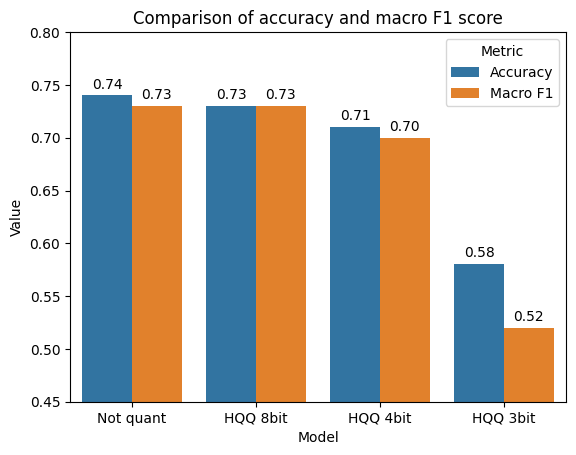

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit'],
    'Accuracy': [0.74, 0.73, 0.71, 0.58],
    'Macro F1': [0.73, 0.73, 0.70, 0.52]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of accuracy and macro F1 score')
plt.ylim(0.45, 0.8)
plt.show()

We observe how the accuracy is higher with the base model and, between the quantized models, the 8-bit variant has a higher accuracy. The results obtained for the 4bit variant are worse than the ones for the 8 bit one, but the difference is not considerably high. However, the results obtained for the 3 bit model are really poor.


### Memory use results

Measuring memeory needs is not an easy task. We decided to check the maximum memory need while inference (in GPU). Note that this measure tends to be higher due to needs associated with inference, specially when using batches.

We only measured this and not the disk memory required because of the way we store the models. Since we used LoRA to fine tune and train our base model with the classification layer, we don't store the whole model explicitly, but only the LoRA adpaters generated. Therefore, we are unable to compare additional memory usage metrics, such as disk memory requirements.

Now we show the maximum memory needed for inference for each model and inference configuration:

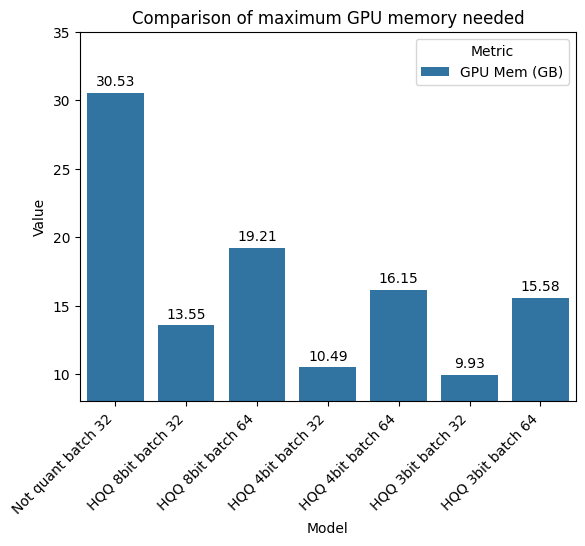

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant batch 32', 'HQQ 8bit batch 32', 'HQQ 8bit batch 64', 'HQQ 4bit batch 32', 'HQQ 4bit batch 64', 'HQQ 3bit batch 32', 'HQQ 3bit batch 64'],
    'GPU Mem (GB)': [30.53, 13.55, 19.21, 10.49, 16.15, 9.93, 15.58]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of maximum GPU memory needed')
plt.ylim(8.0, 35.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how the maximum memory usage in GPU during inference increases with batch size for all models. The bigger the batch size, the higher the memory needs. In addition to this, we see how the base model needs considerable more memory compared to all quantized models, and between the quantized models, the 3bit variant requires less memory than the others. In fact, the lower the bit count, the less memory is needed.

### Inference speed results

In this section we show the results obtained for inference time and quantization time:  

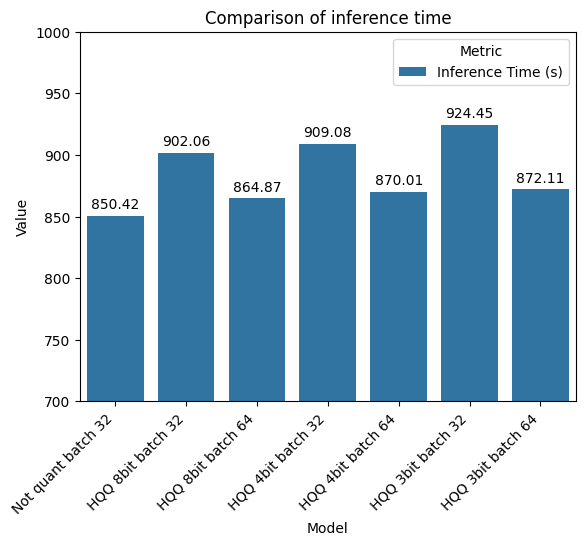

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant batch 32', 'HQQ 8bit batch 32', 'HQQ 8bit batch 64', 'HQQ 4bit batch 32', 'HQQ 4bit batch 64', 'HQQ 3bit batch 32', 'HQQ 3bit batch 64'],
    'Inference Time (s)': [850.42, 902.06, 864.87, 909.08, 870.01, 924.45, 872.11]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of inference time')
plt.ylim(700.0, 1000.0)
plt.xticks(rotation=45, ha='right')
plt.show()

Here we see some surprising results. Opposite to what would be expected, the base model performs better than all the quantized models. Between these, it seems like the lower the bit count, the slower is the model, which is very surprising, although differences are minimal. 

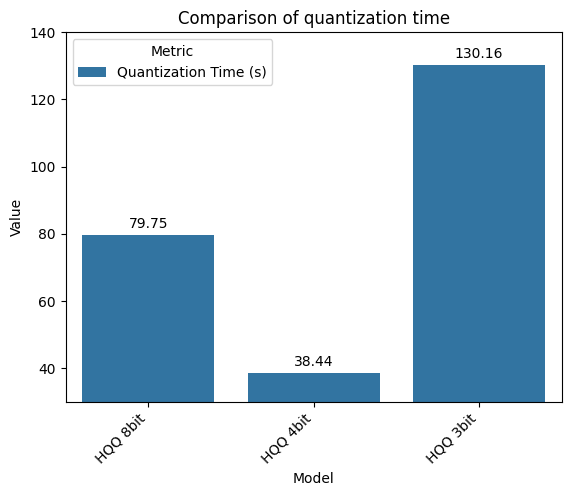

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit'],
    'Quantization Time (s)': [79.749, 38.437, 130.165]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of quantization time')
plt.ylim(30.0, 140.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We also see some surprising results here. The fastest model to be quantized was the 4bit variant. But the 8bit model was faster to quantize than the 3bit one. which was the slowest one.

### Emissions results

The emissions are a little challenging to measure and compare. This is because we need to decide if we take into account the emissions generated during the quantization of the models. Our approach will show the resuts obtained for evaluation separated from the emissions for the quantization process, but will take them into consideration when comparing. We will measure the emissions of CO<sub>2</sub> in kilograms of CO<sub>2</sub>-equivalents \[CO<sub>2</sub>eq\]

The emissions generated by the evaluation process and the quantization were:

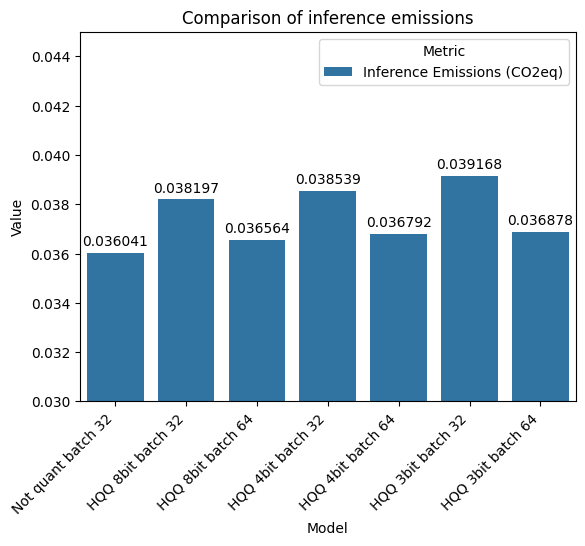

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant batch 32', 'HQQ 8bit batch 32', 'HQQ 8bit batch 64', 'HQQ 4bit batch 32', 'HQQ 4bit batch 64', 'HQQ 3bit batch 32', 'HQQ 3bit batch 64'],
    'Inference Emissions (CO2eq)': [0.036041, 0.038197, 0.036564, 0.038539, 0.036792, 0.039168, 0.036878]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.6f', padding=3)
plt.title('Comparison of inference emissions')
plt.ylim(0.03, 0.045)
plt.xticks(rotation=45, ha='right')
plt.show()

Here we see how the emissions results follow the same trend seen in speed results. Opposite to what would be expected, the base model has lower emissions than all the quantized models. Between these, it seems like the lower the bit count, the higher emissions which is very surprising, although differences are minimal. 

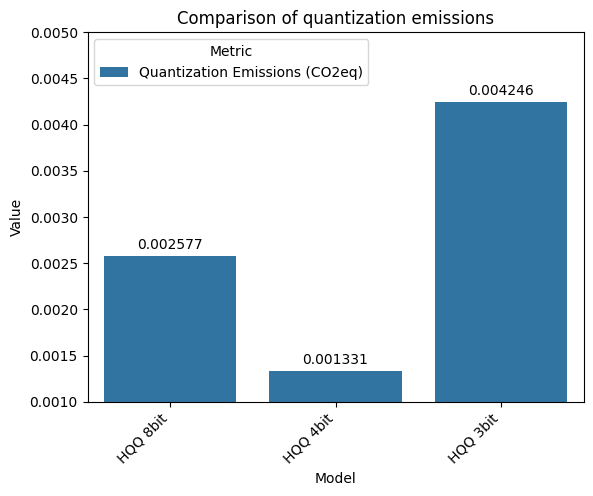

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit'],
    'Quantization Emissions (CO2eq)': [0.002577, 0.001331, 0.004246]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.6f', padding=3)
plt.title('Comparison of quantization emissions')
plt.ylim(0.001, 0.005)
plt.xticks(rotation=45, ha='right')
plt.show()

Again, these results follow the same trend than the ones seen with speed. The 4bit model is the one that has lower emissions for quantization, while the 3bit variant is the one with higher emissions.


## Conclusions

Results show that:

1. Quantization does in fact reduce accuracy, and the lower the bit count, the higher this drop is. However, the drop with **HQQ** is not as significant (if we don't consider the 3bit model), as we saw. 
2. Quantized models are noticeably better in terms of memory usage compared to the base model. 
3. Contrary to what would be expected, quantized models with **HQQ** are not faster than the base model. This probably is due to the nature of this quantization method.
4. In a similar fashion as inference time, emissions are higher in the quantized models. This is coherent with the fact that the inference time is higher. 

